In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys

if "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES" not in sys.path:
  sys.path.append("/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES")


BASE_PATH = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/"

dataset_test_path = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/data/datasets/bbc-news/BBC News Test.csv"
dataset_train_path = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/data/datasets/bbc-news/BBC News Train.csv"
model_path = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/bbc-model"

Mounted at /content/drive


In [2]:
import pandas as pd
train_df=pd.read_csv(dataset_train_path)
test_df=pd.read_csv(dataset_test_path)
train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
train_df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [4]:
train_df['encoded_cat'] = train_df['Category'].astype('category').cat.codes
train_df.head()

,ArticleId,Text,Category,encoded_cat
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,4
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [5]:
#test_df['encoded_cat'] = test_df['Category'].astype('category').cat.codes
#test_df.head()

In [6]:
X=list(train_df['Text'])
y=list(train_df['encoded_cat'])


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42,stratify=y)
#X_train[:5]

In [8]:
!pip install transformers;
!pip install torch;

In [9]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [11]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [12]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir=BASE_PATH + "/models/bbc-model",          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    logging_steps=5,
    eval_steps=100,
    disable_tqdm=False

)

In [13]:
with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

trainer = TFTrainer(
    model=trainer_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)


trainer.train()

# save the model
trainer.save_model()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [14]:
trainer.evaluate(test_dataset)


{'eval_loss': 0.2859929988258763}

In [15]:
trainer.predict(test_dataset)


PredictionOutput(predictions=array([[-0.6928097 ,  0.26923767, -0.6577812 , -0.9813321 ,  1.8410512 ],
       [-0.75816673,  2.366241  , -0.6386131 , -0.49061477, -0.60290354],
       [-0.53708184, -0.35665786, -0.78236914,  2.3768976 , -0.99817604],
       ...,
       [-0.36454734, -0.6048425 , -0.6026959 , -0.9824756 ,  2.3173718 ],
       [-0.81457216,  2.4080052 , -0.74541724, -0.5170769 , -0.5024608 ],
       [-0.8320521 ,  2.3882403 , -0.7156781 , -0.5665244 , -0.43344408]],
      dtype=float32), label_ids=array([4, 1, 3, 2, 2, 4, 1, 0, 1, 1, 0, 2, 2, 3, 1, 0, 0, 1, 0, 1, 4, 3,
       4, 2, 4, 3, 3, 1, 2, 1, 0, 1, 0, 2, 4, 0, 2, 2, 3, 1, 0, 4, 3, 3,
       0, 4, 3, 1, 4, 0, 3, 1, 3, 2, 4, 2, 0, 2, 0, 3, 0, 2, 3, 4, 3, 4,
       1, 2, 1, 2, 1, 0, 3, 4, 3, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 2, 4, 4,
       1, 0, 4, 0, 1, 3, 2, 0, 2, 3, 0, 0, 1, 0, 1, 4, 3, 4, 3, 4, 0, 2,
       3, 1, 2, 0, 0, 0, 0, 0, 1, 4, 1, 4, 0, 3, 2, 0, 0, 2, 0, 0, 4, 2,
       4, 0, 0, 0, 1, 4, 3, 3, 4, 0, 3, 3, 2

In [9]:
from sklearn.metrics import classification_report
target_names = ['business','entertainment','politics','sport','tech']
print(classification_report(y_test,
                            trainer.predict(test_dataset)[1],target_names=target_names
                           )
     )

NameError: ignored

In [10]:
import numpy as np
import matplotlib.pyplot as plt

target_names = ['business','entertainment','politics','sport','tech']

def radar_chart(categories, values_array, title='Radar Chart'):
    # Number of categories
    num_categories = len(categories)

    # Calculate angle for each category
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

    values_copy=[]
    # Make the plot circular
    for i in range(len(values_array)):
      values_copy.append(values_array[i] + values_array[i][:1])
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for i in range(len(values_array)):
      ax.fill(angles, values_copy[i], alpha=0.25)

    # Set the y-axis limit to 1
    ax.set_ylim(0, 1)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Add a title
    plt.title(title, size=12, color='blue', y=1.1)

    # Show the plot
    plt.show()


Some layers from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/bbc-model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/bbc-model and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be 

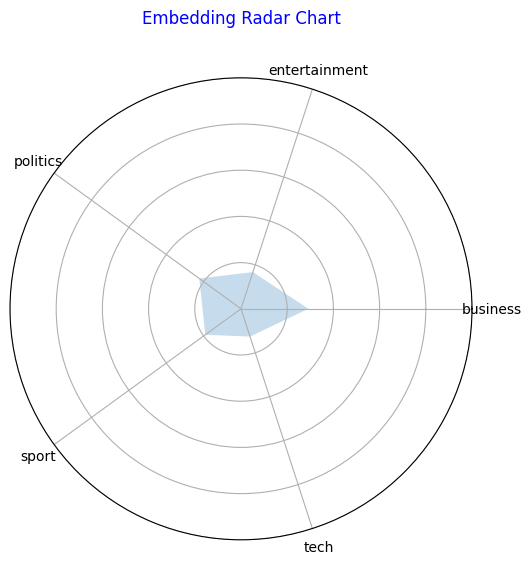

In [13]:
from transformers import TextClassificationPipeline, DistilBertTokenizerFast, TFDistilBertForSequenceClassification

tokenizer_inference = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
trainer_model_inference = TFDistilBertForSequenceClassification.from_pretrained(model_path)

input_text = """
At least 126 people have been killed in north-west China in the country's deadliest earthquake for years.

The 6.2 magnitude quake hit mountainous Gansu province around midnight on Monday (16:00 GMT), also shaking neighbouring Qinghai.

Fatalities may rise with more than 700 reported injured in icy conditions.

Chinese President Xi Jinping has ordered thousands of rescue crew to the region, among the poorest and most diverse in China.
"""

pipe = TextClassificationPipeline(model=trainer_model_inference, tokenizer=tokenizer_inference, return_all_scores=True)

#trainer.predict(input_embeddings)

res=pipe(input_text)

scores = []
for row in res[0]:
  scores.append(row["score"])

# Example usage
categories = target_names
values = scores

radar_chart(categories, [values], title='Embedding Radar Chart')

Some layers from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/bbc-model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/bbc-model and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be

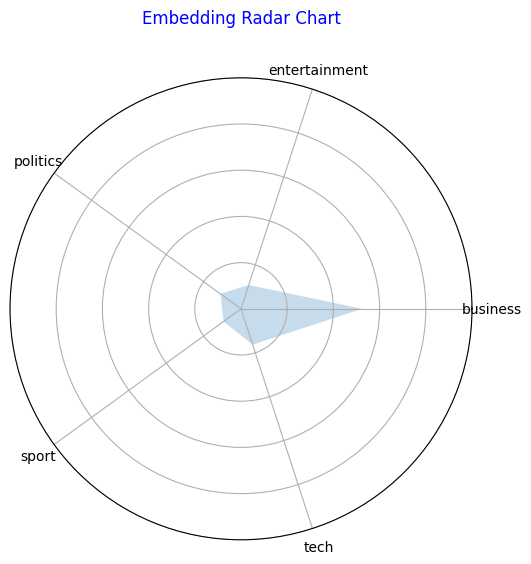

In [14]:
from transformers import TextClassificationPipeline, DistilBertTokenizerFast, TFDistilBertForSequenceClassification

tokenizer_inference = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
trainer_model_inference = TFDistilBertForSequenceClassification.from_pretrained(model_path)

input_text = """
Shein, a Chinese fast-fashion retailer, is being grilled by U.S. regulators about its relationship with China and its data protections. The company is preparing for an IPO in the United States.
"""

pipe = TextClassificationPipeline(model=trainer_model_inference, tokenizer=tokenizer_inference, return_all_scores=True)

#trainer.predict(input_embeddings)

res_2=pipe(input_text)

scores_2 = []
for row in res_2[0]:
  scores_2.append(row["score"])

scores_2

categories = target_names
values_2 = scores_2

radar_chart(categories, [values_2], title='Embedding Radar Chart')

In [29]:
# Convert lists to numpy arrays
vector1 = np.array(values)
vector2 = np.array(values_2)

normalized_v1 =  vector1 / np.linalg.norm(vector1)
normalized_v2 = vector2 / np.linalg.norm(vector2)

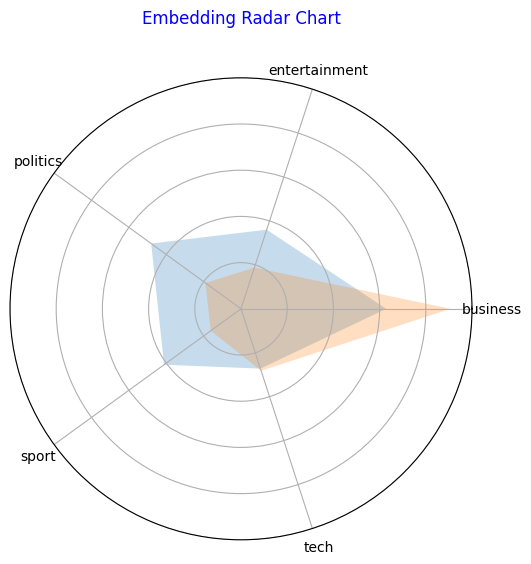

In [31]:
radar_chart(categories, [normalized_v1.tolist(), normalized_v2.tolist()], title='Embedding Radar Chart')

In [33]:
import numpy as np

# compute similarity
similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
similarity

0.8730586231045554

In [35]:
similarity_2 = np.dot(normalized_v1, normalized_v2)
similarity_2

0.8730586231045554